In [8]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import matplotlib
from school_greedy_real import *
from recovery_functions import *

In [9]:
import pickle
results = pickle.load( open( "results_tmp.pkl", "rb" ) )
orders, costs, labels = results

In [10]:
order_base = orders[0]
cost_base = costs[0]

In [11]:
total_results = pickle.load(open('results_realistic.pkl', "rb"))

# Import Data

In [12]:
schools = pd.read_csv('schools_tanjung.csv')
schools.rename(columns = {'Unnamed: 0': 'field_1'}, inplace = True)
distance = pd.read_csv('tanjung_distance.csv') # distance between schools considering road

# define function to change RB, RS, RR to 3,2,1,0
conditions = [
    (schools['damage'] == 'BAIK'),
    (schools['damage'] == 'RR'),
    (schools['damage'] == 'RS'),
    (schools['damage'] == 'RB')
]

values = [0,1,2,3]
schools['damage_level'] = np.select(conditions,values)

cols = ['entry_cost', 'network_cost', 'exit_cost', 'total_cost']
distance.loc[distance['origin_id'] == distance['destination_id'],cols] = 0

schools_id = schools['field_1'].values
ds = schools['damage_level'].values

demand_list = schools['total_students'].values
demand = dict(zip(schools['field_1'], schools['total_students']))

classroom_list = schools['classroom'].values
classroom = dict(zip(schools['field_1'], schools['classroom']))

cons_time_list = schools['days'].values
cons_time = dict(zip(schools['field_1'], schools['days']))

# for new greedy
distance_matrix = {}
for i in schools_id:
    for j in schools_id:
        dst = get_distance(i, j, distance)
        distance_matrix[i,j] = dst

# # for old greedy function
# distance_matrix_array = []
# for i in range(len(schools_id)):
#     row = []
#     for j in range(len(schools_id)):
#         dst = get_distance(schools_id[i],  schools_id[j], distance)
#         row.append(dst)
#     distance_matrix_array.append(row)

In [13]:
# Using coordinates from trans-loc
distance_temp = pd.read_csv('distance_tempschool_lp.csv')

In [14]:
# temporary schools
tmpschool_id = distance_temp['destination_id'].unique()
for i in tmpschool_id:
    demand[i] = 0
    classroom[i] = 12
    
distance_matrix = {}
for i in schools_id:
    for j in schools_id:
        dst = get_distance(i, j, distance)
        distance_matrix[i,j] = dst
    for k in tmpschool_id:
        dst = get_distance(i, k, distance_temp)
        distance_matrix[i,k] = dst

# Basecase

In [15]:
P = 1000
M = 2
B = 50

In [5]:
# Greedy basecase
P = 1000
M = 2
B = 50
order_base, cost_base, last_base, costred_base = greedy_capacity_tmp(schools_id, tmpschool_id, ds, demand, cons_time, 
                                                                     classroom, distance_matrix, B, M, P)

In [102]:
# Naive policies
order_demand = get_demand_order(schools_id, ds, demand_list)
order_damage_demand = get_damage_demand_order(schools_id, ds, demand_list)
order_time_demand = get_time_demand_order(schools_id,ds,cons_time, demand_list)

In [103]:
cost_demand_tmp = naive_capacity_tmp(order_demand, schools_id, tmpschool_id, ds, demand, classroom, distance_matrix, B, M, P)
cost_damage_demand_tmp = naive_capacity_tmp(order_damage_demand, schools_id, tmpschool_id, ds, demand, classroom, distance_matrix, B, M, P)
cost_time_demand_tmp = naive_capacity_tmp(order_time_demand, schools_id, tmpschool_id, ds, demand, classroom, distance_matrix, B, M, P)

In [173]:
orders = [order_base, order_demand, order_damage_demand, order_time_demand]
costs = [cost_base, cost_demand_tmp, cost_damage_demand_tmp, cost_time_demand_tmp]
labels = ['Greedy', 'Demand', 'Damage + Demand', 'Time + Demand']

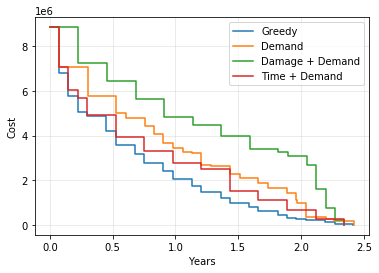

In [224]:
# Need to convert ordering into multiple contractors
sim_time = 2500
num_cons = 2
data_finish = []

results_base = {}
plt.figure()
for i in range(len(orders)):
    
    # change ordering to be in index form
    order = [np.where(schools_id == orders[i][j])[0][0] for j in range(len(orders[i]))]
    
    data_comp, _, x_time = simulate_recovery(num_cons, ds, cons_time_list, order, sim_time)
    plt.plot(x_time/365, costs[i], drawstyle = 'steps-post', label = labels[i])
    results_base[labels[i]] = np.trapz(costs[i], x_time/365)
    data_finish.append(data_comp)

plt.grid(alpha = 0.3)
plt.xlabel('Years')
plt.ylabel('Cost')
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
plt.legend()
plt.show()

In [106]:
pd.DataFrame.from_dict(results_base, orient = 'index', columns = ['Area'])

,Area
Greedy,5.229747e+06
Demand,7.712206e+06
Damage + Demand,1.086080e+07
Time + Demand,6.457115e+06


In [186]:
crews = [1,2]
cont_id = crews * len(schools_id)

In [310]:
order = [np.where(schools_id == order_base[j])[0][0] for j in range(len(order_base))]

In [317]:
print(order)

[13, 32, 19, 10, 2, 4, 3, 30, 0, 7, 16, 8, 5, 26, 33, 11, 31, 1, 29, 14, 18, 28, 6, 21, 20, 17]


In [318]:
schools_idx = schools.set_index('field_1')
schools_idx.loc[schools_id[order[0]], 'index']

13

In [327]:
def plot_gantt(tmp, title, order_base, schools, schools_id):

    crew1 = [tmp[0]]
    c1_start = tmp[0][2]

    for i in range(1,len(tmp)):
        if tmp[i][1] == c1_start:
            crew1.append(tmp[i])
            c1_start = tmp[i][2]

    crew2 = [tmp[1]]
    c2_start = tmp[1][2]

    for i in range(1,len(tmp)):
        if tmp[i] not in crew1 and tmp[i][1] == c2_start:
            crew2.append(tmp[i])
            c2_start = tmp[i][2]

    # make dictionary for plotting purposes
    SCHEDULE = {}
    
    for i in range(len(crew1)):
        SCHEDULE[crew1[i][0]] = [{'start': crew1[i][1]/365, 'finish': crew1[i][2]/365, 'machine': 1}]

    for i in range(len(crew2)):
        SCHEDULE[crew2[i][0]] = [{'start': crew2[i][1]/365, 'finish': crew2[i][2]/365, 'machine': 2}]
    
    # get correct index
    schools_idx = schools.set_index('field_1')
    
    # choose coloring
    cmap = plt.cm.RdBu
    order = [np.where(schools_id == order_base[j])[0][0] for j in range(len(order_base))]
    for i in range(len(order)):
        SCHEDULE[order[i]][0]['color'] = cmap(1.*i/len(order))
        SCHEDULE[order[i]][0]['index'] = schools_idx.loc[schools_id[order[i]], 'index']

    plt.figure(figsize=(12, 0.7*len(crews)))
    bw = 0.3
    for j in SCHEDULE.keys():
        for k in range(len(SCHEDULE[j])):
            idx = crews.index(SCHEDULE[j][k]['machine'])
            x = SCHEDULE[j][k]['start']
            y = SCHEDULE[j][k]['finish']
            plt.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color=SCHEDULE[j][k]['color'], alpha=0.5)
            plt.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k', linewidth = 0.7)
            plt.text((SCHEDULE[j][k]['start'] + SCHEDULE[j][k]['finish'])/2.0,idx,
                SCHEDULE[j][k]['index'], color='black', 
                horizontalalignment='center', verticalalignment='center')
    plt.xlim(-0.1, 2.5)
    plt.ylim(-0.5, len(crews)-0.5)
    plt.title(title)
    plt.yticks(range(len(crews)), crews)
    plt.xlabel('Years')
    plt.ylabel('Construction Crew')
    plt.gca().xaxis.grid(True, alpha = 0.4)

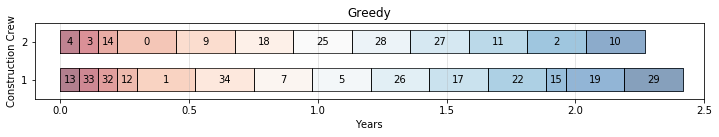

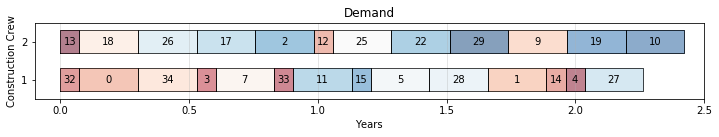

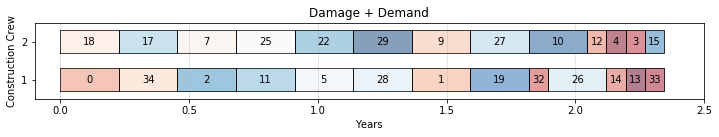

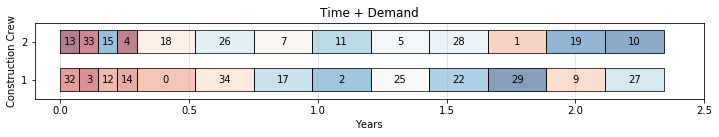

In [328]:
for j in range(len(data_finish)):
#     print(labels[j])
    tmp = data_finish[j]
    plot_gantt(tmp, labels[j], order_base, schools, schools_id)

In [78]:
B = 50
P = 1000
M = 2

## Disaggregated by schools

In [65]:
# Disaggregated by schools
order_disagg, _,_,_, cost_school_disagg = greedy_capacity_diff(schools_id, tmpschool_id, ds, demand, cons_time, 
                                                                                                  classroom, distance_matrix, B, M, P)
demand_cost_disagg, demand_cost_school_disagg = naive_capacity_diff(order_demand, schools_id, tmpschool_id, ds, demand, classroom, distance_matrix, B, M, P)
demanddamage_cost_disagg, demanddamage_cost_school_disagg = naive_capacity_diff(order_damage_demand, schools_id, tmpschool_id, ds, demand, classroom, distance_matrix, B, M, P)
timedemand_cost_disagg, timedemand_cost_school_disagg = naive_capacity_diff(order_time_demand, schools_id, tmpschool_id, ds, demand, classroom, distance_matrix, B, M, P)

In [109]:
orders = [order_disagg, order_demand, order_damage_demand, order_time_demand]
costs = [cost_school_disagg, demand_cost_school_disagg, demanddamage_cost_school_disagg, timedemand_cost_school_disagg]
labels = ['Greedy', 'Demand', 'Damage + Demand', 'Time + Demand']
damaged_schools = schools_id[ds != 0]

results_disagg = {}

for i in range(len(orders)):
    
    # change ordering to be in index form
    order = [np.where(schools_id == orders[i][j])[0][0] for j in range(len(orders[i]))]
    
    _, _, x_time = simulate_recovery(num_cons, ds, cons_time_list, order, sim_time)
        
    for j in damaged_schools:
        if j not in results_disagg.keys():
            results_disagg[j] = {}
        results_disagg[j][labels[i]] = np.trapz(costs[i][j], x_time/365)
results_disagg = pd.DataFrame.from_dict(results_disagg, orient= 'index')

demand_damage = {school: demand[school] for school in schools_id[ds != 0]}
results_disagg_norm = results_disagg.divide(demand_damage, axis = 0)
idx = [schools.loc[schools['field_1'] == i, 'index'].tolist()[0] for i in damaged_schools]
results_disagg_norm_idx = results_disagg_norm.copy()
results_disagg_norm_idx.index = idx

order_disagg_idx = [schools.loc[schools['field_1'] == i, 'index'].tolist()[0] for i in order_disagg]
order_demand_idx =[schools.loc[schools['field_1'] == i, 'index'].tolist()[0] for i in order_demand]
ds_damage_order_idx = [schools.loc[schools['field_1'] == i, 'index'].tolist()[0] for i in order_damage_demand]
time_demand_order_idx = [schools.loc[schools['field_1'] == i, 'index'].tolist()[0] for i in order_time_demand]

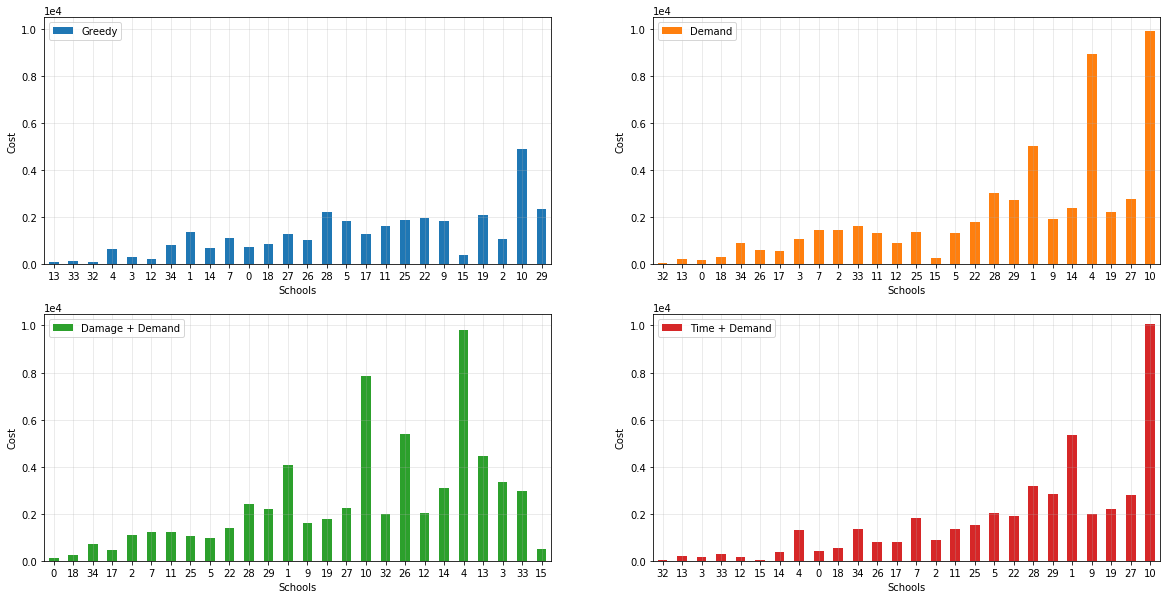

In [112]:
# Normalized sorted by each policy
plt.figure(figsize = (20,10))

plt.subplot(2,2,1)
results_disagg_norm_idx['Greedy'][order_disagg_idx].plot.bar(label = labels[0])
plt.ylim([0, 1.05e4])
plt.grid(alpha = 0.3)
plt.xlabel('Schools')
plt.xticks(rotation = 0)
plt.ylabel('Cost')
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
plt.legend(loc = 'upper left')

plt.subplot(2,2,2)
results_disagg_norm_idx['Demand'][order_demand_idx].plot.bar(color= 'tab:orange', label = labels[1])
plt.ylim([0, 1.05e4])
plt.grid(alpha = 0.3)
plt.xlabel('Schools')
plt.xticks(rotation = 0)
plt.ylabel('Cost')
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
plt.legend(loc = 'upper left')

plt.subplot(2,2,3)
results_disagg_norm_idx['Damage + Demand'][ds_damage_order_idx].plot.bar(color= 'tab:green', label = labels[2])
plt.ylim([0, 1.05e4])
plt.grid(alpha = 0.3)
plt.xlabel('Schools')
plt.xticks(rotation = 0)
plt.ylabel('Cost')
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
plt.legend(loc = 'upper left')

plt.subplot(2,2,4)
results_disagg_norm_idx['Time + Demand'][time_demand_order_idx].plot.bar(color= 'tab:red', label = labels[3])
plt.ylim([0, 1.05e4])
plt.grid(alpha = 0.3)
plt.xlabel('Schools')
plt.xticks(rotation = 0)
plt.ylabel('Cost')
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
plt.legend(loc = 'upper left')

plt.show()

# Sensitivity Studies

## Number of Construction Crews

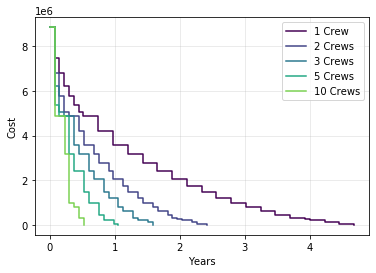

In [115]:
# greedy order is the same
num_contractors = [1,2,3,5,10]
sim_time = 2500
greedy_order = [np.where(schools_id == order_base[i])[0][0] for i in range(len(order_base))]

norm = matplotlib.colors.Normalize(vmin=0, vmax=len(num_contractors))
cmap = matplotlib.cm.get_cmap("viridis")

results_cons = {}
plt.figure()
for i in range(len(num_contractors)):
    _, _, x_time = simulate_recovery(num_contractors[i], ds, cons_time_list, greedy_order, sim_time)
    if i == 0: 
        plt.plot(x_time/365, cost_base, drawstyle = 'steps-post', label = str(num_contractors[i]) + ' Crew', color = cmap(norm(i)))
    else: 
        plt.plot(x_time/365, cost_base, drawstyle = 'steps-post', label = str(num_contractors[i]) + ' Crews',color = cmap(norm(i)))
    results_cons[num_contractors[i]] = np.trapz(cost_base, x_time/365)
    
plt.grid(alpha = 0.3)
plt.xlabel('Years')
plt.ylabel('Cost')
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
plt.legend()
plt.show()

In [116]:
pd.DataFrame.from_dict(results_cons, orient = 'index', columns = ['Area'])

,Area
1,9.768705e+06
2,5.229747e+06
3,3.734820e+06
5,2.544959e+06
10,1.662966e+06


## Number of Moves

In [30]:
order_move3, cost_move3, last_move3,_ = greedy_capacity_tmp(schools_id, tmpschool_id, ds, demand, cons_time, classroom, distance_matrix, B, 3, P)
order_move1, cost_move1, last_move1,_ = greedy_capacity_tmp(schools_id, tmpschool_id, ds, demand, cons_time, classroom, distance_matrix, B, 1, P)

In [117]:
orders = [order_move1, order_base, order_move3]
costs = [cost_move1, cost_base, cost_move3]
labels = ['1 Move', '2 Moves', '3 Moves']

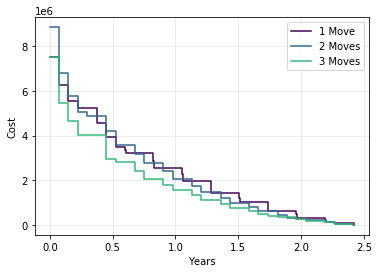

In [118]:
results_move = {}

norm = matplotlib.colors.Normalize(vmin=0, vmax=len(orders))
cmap = matplotlib.cm.get_cmap("viridis")

plt.figure()
for j in range(len(orders)):
    
    # change ordering to be in index form
    order = [np.where(schools_id == orders[j][i])[0][0] for i in range(len(orders[j]))]
    _, _, x_time = simulate_recovery(num_cons, ds, cons_time_list, order, sim_time)
    
    plt.plot(x_time/365, costs[j], drawstyle = 'steps-post', label = labels[j], color = cmap(norm(j)))
    
    results_move[labels[j]] = np.trapz(costs[j], x_time/365)
    
plt.grid(alpha = 0.3)
plt.xlabel('Years')
plt.ylabel('Cost')
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
plt.legend()
plt.show()

In [119]:
pd.DataFrame.from_dict(results_move, orient = 'index', columns = ['Area'])

,Area
1 Move,5.344774e+06
2 Moves,5.229747e+06
3 Moves,4.091220e+06


## Student-to-Classroom Ratio

In [34]:
order_b60, cost_b60, _,_ = greedy_capacity_tmp(schools_id, tmpschool_id, ds, demand, cons_time, classroom, distance_matrix, 60, M, P)
order_b70, cost_b70, _,_ = greedy_capacity_tmp(schools_id, tmpschool_id, ds, demand, cons_time, classroom, distance_matrix, 70, M, P)
order_b80, cost_b80, _,_ = greedy_capacity_tmp(schools_id, tmpschool_id, ds, demand, cons_time, classroom, distance_matrix, 80, M, P)
order_b90, cost_b90, _,_ = greedy_capacity_tmp(schools_id, tmpschool_id, ds, demand, cons_time, classroom, distance_matrix, 90, M, P)
order_b100, cost_b100, _,_ = greedy_capacity_tmp(schools_id, tmpschool_id, ds, demand, cons_time, classroom, distance_matrix, 100, M, P)

In [121]:
orders = [order_base, order_b60, order_b70, order_b80, order_b90, order_b100]
costs = [cost_base, cost_b60, cost_b70, cost_b80, cost_b90, cost_b100]
labels = ['B = 50','B = 60', 'B = 70', 'B = 80', 'B = 90', 'B = 100']

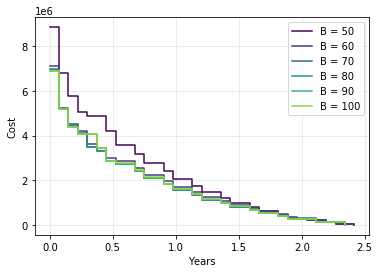

In [122]:
results_b = {}
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(orders))
cmap = matplotlib.cm.get_cmap("viridis")

plt.figure()
for j in range(len(orders)):
    # change ordering to be in index form
    order = [np.where(schools_id == orders[j][i])[0][0] for i in range(len(orders[j]))]
    _, _, x_time = simulate_recovery(num_cons, ds, cons_time_list, order, sim_time)
    
    plt.plot(x_time/365, costs[j], drawstyle = 'steps-post', label = labels[j], color = cmap(norm(j)))
    
    results_b[labels[j]] = np.trapz(costs[j], x_time/365)
    
plt.grid(alpha = 0.3)
plt.xlabel('Years')
plt.ylabel('Cost')
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
plt.legend()
plt.show()

In [123]:
pd.DataFrame.from_dict(results_b, orient = 'index', columns = ['Area'])

,Area
B = 50,5.229747e+06
B = 60,4.200945e+06
B = 70,4.022871e+06
B = 80,3.992895e+06
B = 90,4.050749e+06
B = 100,4.060781e+06


## Number of Classrooms

In [79]:
classroom_vals = [11,12,15,20]
orders_size = []
costs_size = []
for n in range(len(classroom_vals)):
    demand = dict(zip(schools['field_1'], schools['total_students']))
    classroom = dict(zip(schools['field_1'], schools['classroom']))
    
    for i in tmpschool_id:
        demand[i] = 0
        classroom[i] = classroom_vals[n]
    
    print('classroom size:', classroom_vals[n])
    order, cost, _, _ = greedy_capacity_tmp(schools_id, tmpschool_id, ds, demand, cons_time, classroom, distance_matrix, B, M, P)
    
    orders_size.append(order)
    costs_size.append(cost)

classroom size: 11
classroom size: 12
classroom size: 15
classroom size: 20


In [80]:
# orders = [orders_size[0], order_base, orders_size[1], orders_size[2]]
# costs = [costs_size[0], cost_base, costs_size[1], costs_size[2]]
# labels = ['11 classrooms', '12 classrooms', '15 classrooms', '20 classrooms']

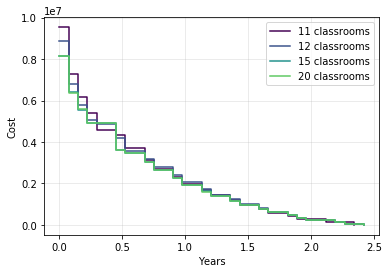

In [126]:
results_size = {}

norm = matplotlib.colors.Normalize(vmin=0, vmax=len(orders_size))
cmap = matplotlib.cm.get_cmap("viridis")
labels = ['11 classrooms', '12 classrooms', '15 classrooms', '20 classrooms']

plt.figure()
for j in range(len(orders_size)):
    # change ordering to be in index form
    order = [np.where(schools_id == orders_size[j][i])[0][0] for i in range(len(orders_size[j]))]
    _, _, x_time = simulate_recovery(num_cons, ds, cons_time_list, order, sim_time)
    
    plt.plot(x_time/365, costs_size[j], drawstyle = 'steps-post', label = labels[j], color = cmap(norm(j)))
    
    results_size[labels[j]] = np.trapz(costs_size[j], x_time/365)
    
plt.grid(alpha = 0.3)
plt.xlabel('Years')
plt.ylabel('Cost')
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
plt.legend()
plt.show()

In [127]:
pd.DataFrame.from_dict(results_size, orient = 'index', columns = ['Area'])

,Area
11 classrooms,5.295092e+06
12 classrooms,5.229747e+06
15 classrooms,4.970438e+06
20 classrooms,4.972589e+06


## Penalty

In [90]:
Ps = [0,50,100,500,1000]
B = 50
M = 2

orders_penalty = []
costs_penalty = []
costs_np_penalty = []
last_tmp_penalty = []

for i in range(len(Ps)):
    order, cost, cost_np, last_tmp,_ = greedy_capacity_np(schools_id, tmpschool_id, ds, demand, cons_time, classroom, distance_matrix, B, M, Ps[i])
    
    orders_penalty.append(order)
    costs_penalty.append(cost)
    costs_np_penalty.append(cost_np)
    last_tmp_penalty.append(last_tmp)

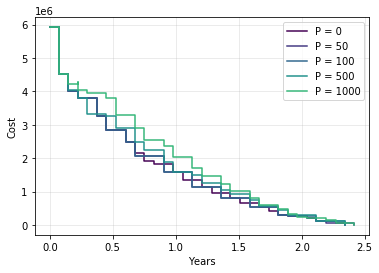

In [132]:
results_penalty_np = {}

norm = matplotlib.colors.Normalize(vmin=0, vmax=len(orders_penalty)+1)
cmap = matplotlib.cm.get_cmap("viridis")

plt.figure()
for j in range(len(orders_penalty)):
    # change ordering to be in index form
    order = [np.where(schools_id == orders_penalty[j][i])[0][0] for i in range(len(orders_penalty[j]))]
    _, _, x_time = simulate_recovery(num_cons, ds, cons_time_list, order, sim_time)
    
    label_plot = "P = "+ str(Ps[j])
    plt.plot(x_time/365, costs_np_penalty[j], drawstyle = 'steps-post', label = label_plot, color = cmap(norm(j)))
    
    results_penalty_np[label_plot] = np.trapz(costs_np_penalty[j], x_time/365)
    
plt.grid(alpha = 0.3)
plt.xlabel('Years')
plt.ylabel('Cost')
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
plt.legend()
plt.show()

In [130]:
pd.DataFrame.from_dict(results_penalty_np, orient = 'index', columns = ['Area'])

,Area
P = 0,3.731993e+06
P = 50,3.745343e+06
P = 100,3.758526e+06
P = 500,3.998294e+06
P = 1000,4.484134e+06


In [138]:
last_tmp_penalty

[{94: 992, 91: 1075, 92: 1241, 93: 1324, 95: 1710},
 {94: 992, 91: 1075, 92: 1241, 93: 1324, 95: 1627},
 {94: 992, 91: 1075, 93: 1241, 92: 1324, 95: 1351},
 {95: 162, 92: 272, 93: 770, 91: 1019, 94: 1102},
 {91: 108, 95: 135, 92: 189, 93: 604, 94: 853}]

## Number of Temporary Schools

In [45]:
csvs = ['distance_tempschool_lp.csv','distance_temp8b50.csv', 'distance_temp10b50.csv']

B = 50
M = 2
P = 1000
orders_school = []
costs_school = []
costs_np_school = []
for n in range(len(csvs)):
    distance_temp = pd.read_csv(csvs[n])
    
    demand = dict(zip(schools['field_1'], schools['total_students']))
    classroom = dict(zip(schools['field_1'], schools['classroom']))

    # temporary schools
    tmpschool_id = distance_temp['destination_id'].unique()
    for i in tmpschool_id:
        demand[i] = 0
        classroom[i] = 12

    distance_matrix = {}
    for i in schools_id:
        for j in schools_id:
            dst = get_distance(i, j, distance)
            distance_matrix[i,j] = dst
        for k in tmpschool_id:
            dst = get_distance(i, k, distance_temp)
            distance_matrix[i,k] = dst
            
    print('Number of temp schools:', len(tmpschool_id))
    order, cost, cost_np, _,_ = greedy_capacity_np(schools_id, tmpschool_id, ds, demand, cons_time, classroom, distance_matrix, B, M, P)
    
    orders_school.append(order)
    costs_school.append(cost)
    costs_np_school.append(cost_np)

Number of temp schools: 5
Number of temp schools: 8
Number of temp schools: 10


In [46]:
# orders = [orders_school[0], orders_school[1], orders_school[2]]
# costs = [costs_school[0], costs_school[1], costs_school[2]]
# costs_np = [costs_np_school[0], costs_np_school[1], costs_np_school[2]]

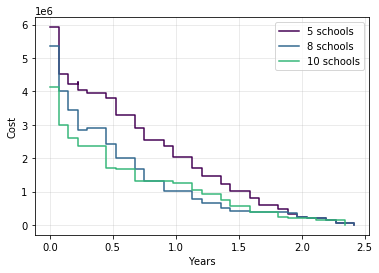

In [133]:
results_schools_np = {}
labels = ['5 schools', '8 schools', '10 schools']

norm = matplotlib.colors.Normalize(vmin=0, vmax=len(orders_school))
cmap = matplotlib.cm.get_cmap("viridis")

plt.figure()
for j in range(len(orders_school)):
    # change ordering to be in index form
    order = [np.where(schools_id == orders_school[j][i])[0][0] for i in range(len(orders_school[j]))]
    _, _, x_time = simulate_recovery(num_cons, ds, cons_time_list, order, sim_time)
    
    plt.plot(x_time/365, costs_np_school[j], drawstyle = 'steps-post', label = labels[j], color = cmap(norm(j)))
    
    results_schools_np[labels[j]] = np.trapz(costs_np_school[j], x_time/365)
    
plt.grid(alpha = 0.3)
plt.xlabel('Years')
plt.ylabel('Cost')
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
plt.legend()
plt.show()

In [134]:
pd.DataFrame.from_dict(results_schools_np, orient = 'index', columns = ['Area'])

,Area
5 schools,4.484134e+06
8 schools,2.874384e+06
10 schools,2.603828e+06


# Combine into Dictionary To Save Variables

In [135]:
total_results =  {}

#Basecase
total_results['order_base'] = order_base
total_results['cost_base'] = cost_base
total_results['results_base'] = results_base
total_results['order_disagg'] =  [order_disagg, order_demand, order_damage_demand, order_time_demand]
total_results['cost_disagg'] = [cost_school_disagg, demand_cost_school_disagg, demanddamage_cost_school_disagg, timedemand_cost_school_disagg]

# Sensitivity: number of construction crews
total_results['results_cons'] = results_cons

# Sennsitivity: Number of moves
total_results['orders_move'] = [order_move1, order_base, order_move3]
total_results['costs_move'] = [cost_move1, cost_base, cost_move3]
total_results['results_move'] = results_move

# sensitivity: student to classroom ratio
total_results['orders_b'] = [order_base, order_b60, order_b70, order_b80, order_b90, order_b100]
total_results['costs_b'] = [cost_base, cost_b60, cost_b70, cost_b80, cost_b90, cost_b100]
total_results['results_b'] = results_b

# Sensitivity: size
total_results['orders_size'] = orders_size
total_results['costs_size'] = costs_size
total_results['results_size'] = results_size

# Sensitivity: penalty
total_results['orders_penalty'] = orders_penalty
total_results['costs_penalty'] = costs_penalty
total_results['costs_np_penalty'] = costs_np_penalty
total_results['results_penalty_np'] = results_penalty_np

# Sensitivity: number of temporary schools
total_results['orders_school'] = orders_school
total_results['costs_school'] = costs_school
total_results['costs_np_school'] = costs_np_school
total_results['results_schools_np'] = results_schools_np

In [136]:
# save as pickle
pickle.dump(total_results, open('results_realistic.pkl', 'wb'))

# Compare with Government

In [16]:
govt_school = np.array([3255, 3294, 3242, 3286, 3271, 3327, 3275, 3311])
ds_repaired = np.array([ds[i] if schools_id[i] in govt_school else 0 for i in range(len(schools_id))])

In [19]:
def greedy_damaged_8(govt_school, schools_id, tmpschool_id, ds, demand, cons_time, classroom, distance_matrix, B, M, P):
    '''
    Function to calculate school reconstruction ordering accounting for capacity, 
    maximum number of moves, and temporary schools.
    Only chooses 8 schools that government chose
    Assumes that other schools won't be reconstructed
    
    Input:
    govt_school: array of school IDs that government chose
    schools_id: array of school IDs in the region
    tmpschool_id: array of temporary school IDs in the region
    ds: array of damage states for all schools in the region (0,1,2,3)
    demand: dict with keys school ID and values number of students enrolled for each school (includes temp school)
    cons_time: dict of reconstruction time with keys school ID and values the construction time in days
    classroom: dict with keys school ID and values the number of classroom in the corresponding school (includes temp school)
    distance_matrix: a dict with keys school ID pairs, and value the distance between the two schools (includes temp school)
    B: maximum student to classroom ratio
    M: maximum number of moves students can perform
    P: penalty for being in the temporary school
    
    Output:
    order: array of school ID ordered based on the greedy algorithm
    cost: array of costs (weighted-demand)
    last_temp: a dict with of the last days students are in each temp school (key is temp school ID, value is day)
    cost_reduction: the cost reduction at each time step
    '''

    num_damaged = len(govt_school)
    undamaged_schools = schools_id[ds == 0]
    damaged_schools = schools_id[ds != 0]
    functional_schools = np.append(undamaged_schools, tmpschool_id) # undamaged + temporary schools

    # total number of students in region
    total_students = sum(demand.values())

    # initial capacity with damaged schools
    initial_capacity = sum([value for key,value in classroom.items() if key in functional_schools])*B

    # initial check if problem is feasible
    if total_students > initial_capacity:
        raise ValueError('Not enough capacity!')

    # Initialize arrays    
    original = np.repeat(schools_id[0], demand[schools_id[0]]) # original schools student went
    for i in range(1, len(schools_id)):
        original = np.append(original, np.repeat(schools_id[i], demand[schools_id[i]])) 
    moves_used = np.zeros(total_students) # number of moves used by students
    where = original.copy()

    # add students to original school
    membership = {school: [] for school in schools_id} 
    for s in range(total_students):
        membership[original[s]].append(s)
    for i in tmpschool_id: # initialize temporary school membership
        membership[i] = []

    # allocate students of damaged schools to nearest functional school, making sure it doesn't exceed capacity
    cost = np.zeros(num_damaged+1)
    for s in range(total_students):
        if original[s] in damaged_schools: # only move students in damaged schools
            potential_school_move = get_nearest_school_order(original[s], distance_matrix, functional_schools)
            for i in range(len(potential_school_move)):
                if len(membership[potential_school_move[i]]) < classroom[potential_school_move[i]]*B: # there is still enough space
                    membership[potential_school_move[i]].append(s)
                    membership[original[s]].remove(s)
                    moves_used[s] += 1
                    where[s] = potential_school_move[i]
                    cost[0] += distance_matrix[(original[s], where[s])] # calculate initial cost
                    if where[s] in tmpschool_id: # add penalty if student in temporary school
                        cost[0] += P
                    break

    order = []
    last_temp = {}
    damaged_curr = govt_school.copy()
    cost_reduction = np.zeros(num_damaged)
    
    for d in range(num_damaged):# loop through damaged schools and reconstruct
        print('School {} out of {}'.format(d, num_damaged))
#         print(damaged_curr)
        potential = np.zeros(len(damaged_curr))

        # calculate gittins index for each damaged school
        index = 0
        for i in damaged_curr:
            _,_,_,potential[index] = calculate_potential_tmp(i, tmpschool_id, membership, moves_used, original, where, 
                                                   distance_matrix, total_students, classroom, B, M, P)
            index += 1

        # choose school with maximum potential
        chosen_school_index = np.argmax(potential/[cons_time[i] for i in damaged_curr])
        chosen_school = damaged_curr[chosen_school_index]
#         print(chosen_school)
        order.append(chosen_school)

        # update all other values
        membership, moves_used, where, cost_reduction[d] = calculate_potential_tmp(chosen_school, tmpschool_id, membership, moves_used, original, 
                                                                            where, distance_matrix, total_students, classroom, B, M, P)
        cost[d+1] = cost[d] - cost_reduction[d]
        damaged_curr = damaged_curr[damaged_curr != chosen_school] # chosen school no longer damaged
#         print(damaged_curr != chosen_school)
        undamaged_schools = np.append(undamaged_schools, chosen_school) # chosen school is now reconstructed
        
        # keep track of the last time period students are in each temporary school
        for i in tmpschool_id:
            if not membership[i] and not i in last_temp.keys(): # no more students in the temporary school
                last_temp[i] = sum([cons_time[j] for j in order])
        
    return order, cost, last_temp, cost_reduction

In [20]:
# assumes only the 8 schools are repaired, the rest are still damaged
order_damage_8, cost_damage_8, _,_ = greedy_damaged_8(govt_school, schools_id, tmpschool_id, ds, demand, cons_time, 
                                                                     classroom, distance_matrix, B, M, P)

School 0 out of 8
School 1 out of 8
School 2 out of 8
School 3 out of 8
School 4 out of 8
School 5 out of 8
School 6 out of 8
School 7 out of 8


In [21]:
order_damage_8

[3242, 3286, 3275, 3271, 3255, 3294, 3327, 3311]

In [163]:
schools_idx = schools.set_index('field_1')
schools_idx.loc[order_damage_8, 'name']

field_1
3242    (50200275) SD NEGERI 2 SIGAR PENJALIN
3286            (50200159) SD NEGERI 2 SOKONG
3275          (50200442) SD NEGERI 4 JENGGALA
3271        (50200183) SD NEGERI 3 TEGAL MAJA
3255               (69933736) SDI Al - Furqan
3294            (50200788) SD NEGERI 1 SOKONG
3327        (50200139) SD NEGERI 2 TEGAL MAJA
3311        (50200431) SD NEGERI 4 TEGAL MAJA
Name: name, dtype: object

In [22]:
cost_govt = naive_capacity_tmp(govt_school, schools_id, tmpschool_id, ds, demand, classroom, distance_matrix, B, M, P)

In [36]:
orders = [order_damage_8, govt_school]
costs = [cost_damage_8, cost_govt[:len(govt_school)+1]]
labels = ['Greedy', 'Reconstruction Data']

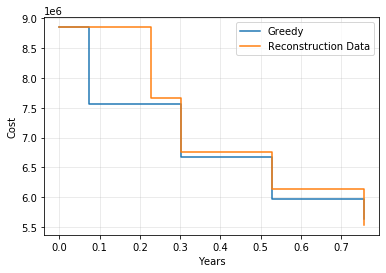

In [38]:
# Need to convert ordering into multiple contractors
sim_time = 2500
num_cons = 2

results_govt = {}
plt.figure()
for i in range(len(orders)):
    
    # change ordering to be in index form
    order = [np.where(schools_id == orders[i][j])[0][0] for j in range(len(orders[i]))]
    
    _, _, x_time = simulate_recovery(num_cons, ds, cons_time_list, order, sim_time)
    plt.plot(x_time/365, costs[i], drawstyle = 'steps-post', label = labels[i])
    results_govt[labels[i]] = np.trapz(costs[i], x_time/365)

plt.grid(alpha = 0.3)
plt.xlabel('Years')
plt.ylabel('Cost')
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
plt.legend()
plt.show()

In [39]:
results_govt

{'Greedy': 5099757.751265857, 'Reconstruction Data': 5307365.835847384}

No handles with labels found to put in legend.


cost:  5099757.751265857


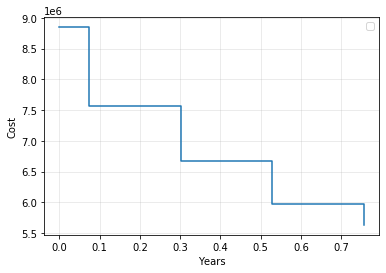

In [165]:
# assumes only the 8 schools are repaired, the rest are still damaged
# Need to convert ordering into multiple contractors
sim_time = 2500
num_cons = 2

plt.figure()
# change ordering to be in index form
order = [np.where(schools_id == order_damage_8[j])[0][0] for j in range(len(order_damage_8))]

data_comp, _, x_time = simulate_recovery(num_cons, ds, cons_time_list, order, sim_time)
plt.plot(x_time/365, cost_damage_8, drawstyle = 'steps-post')
print('cost: ', np.trapz(cost_damage_8, x_time/365))

plt.grid(alpha = 0.3)
plt.xlabel('Years')
plt.ylabel('Cost')
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
plt.legend()
plt.show()

In [168]:
# assumes that all other schools are repaired, except for the 8
order_repaired_8, cost_repaired_8, _,_ = greedy_damaged_8(govt_school, schools_id, tmpschool_id, ds_repaired, demand, cons_time, 
                                                                     classroom, distance_matrix, B, M, P)

School 0 out of 8
School 1 out of 8
School 2 out of 8
School 3 out of 8
School 4 out of 8
School 5 out of 8
School 6 out of 8
School 7 out of 8


In [169]:
schools_idx.loc[order_repaired_8, 'name']

field_1
3242    (50200275) SD NEGERI 2 SIGAR PENJALIN
3286            (50200159) SD NEGERI 2 SOKONG
3271        (50200183) SD NEGERI 3 TEGAL MAJA
3311        (50200431) SD NEGERI 4 TEGAL MAJA
3294            (50200788) SD NEGERI 1 SOKONG
3255               (69933736) SDI Al - Furqan
3275          (50200442) SD NEGERI 4 JENGGALA
3327        (50200139) SD NEGERI 2 TEGAL MAJA
Name: name, dtype: object

No handles with labels found to put in legend.


cost:  368190.2832452289


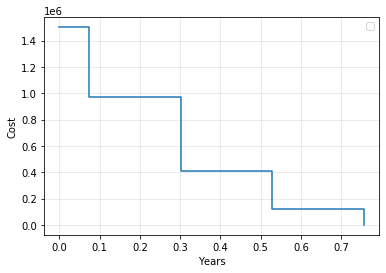

In [170]:
# assumes that all other schools are repaired, except for the 8

# Need to convert ordering into multiple contractors
sim_time = 2500
num_cons = 2

plt.figure()
# change ordering to be in index form
order = [np.where(schools_id == order_repaired_8[j])[0][0] for j in range(len(order_repaired_8))]

data_comp, _, x_time = simulate_recovery(num_cons, ds, cons_time_list, order, sim_time)
plt.plot(x_time/365, cost_repaired_8, drawstyle = 'steps-post')
print('cost: ', np.trapz(cost_repaired_8, x_time/365))

plt.grid(alpha = 0.3)
plt.xlabel('Years')
plt.ylabel('Cost')
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
plt.legend()
plt.show()

In [61]:
x1 = np.array([0,10,30]) # AB
x2 = np.array([0,20,30]) # BA
y1 = np.array([2*15+50*1,50*1,0]) #AB
y2 = np.array([2*15+50*1,15*2,0]) #BA

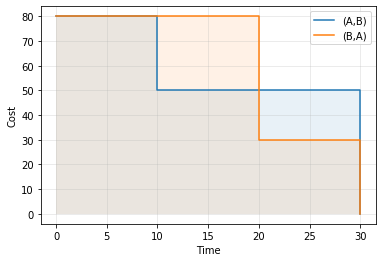

In [62]:
plt.figure()
plt.plot(x1,y1, drawstyle = 'steps-post')
plt.fill_between(x1, 0, y1, step = 'post', alpha = 0.1)

plt.plot(x2,y2, drawstyle = 'steps-post')
plt.fill_between(x2, 0, y2, step = 'post', alpha = 0.1)
plt.xlabel('Time')
plt.ylabel('Cost')
plt.legend(['(A,B)', '(B,A)'], loc = 'upper right')
plt.grid(alpha = 0.3)
plt.show()

In [63]:
np.trapz(y1,x1)

1150.0

In [64]:
np.trapz(y2,x2)

1250.0